# 자전거 수요 예측 대회 ([Kaggle] Bike Sharing Demand)

## 대회의 목표
이 대회에서, 참가자들은 워싱턴 D.C의 자전거 공유 프로그램의 **자전거 대여의 수요량을 예측**하기 위해  시간에 따른 사용패턴과 날씨 데이터를 결합하여 보는 것을 목표로 합니다.

## 목차
0. Colab Notebook에 데이터 다운받기
1. 데이터 불러오기
2. EDA 분석하기
3. Feature Engineering
4. Feature Selection
5. Modeling
6. Prediction
7. Submission

0 ~ 2번 까지는 EDA.ipynb 파일로, 3 ~ 5번 까지는 Model.ipynb 나누어 진행할 예정입니다.


## 0. Colab Notebook에 데이터 다운받기
저와 같이 개인 PC의 사양이 낮아 분석하는 데 어려움을 겪는 분들을 위해 가상환경인 Colab 노트북에서 데이터 분석을 하는 방법을 살펴보겠습니다.

우선 제공되는 데이터를 살펴보기 위해 colab의 환경설정부터 해보겠습니다.

먼저 대략적인 순서는:
1. 자신의 kaggle 계정 API Token (json 형식 파일) 로컬 드라이브에 다운받기
2. Colab 드라이브에 API Token 업로드하기
3. 업로드된 API Token으로 참여 대회 데이터 셋에 액세스 하기 (해당 대회 데이터 셋의 API 주소 필요)

아래 코드를 순서대로 따라해 주세요~

In [13]:
# 다운받은 API Token 업로드 하기
!pip install kaggle

from google.colab import files # → 이미 (만기되지 않은 Token이) 업로드 되어있다면 생략
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mongnyonglee","key":"1f9b2690a6d131428bb2bba9507233af"}'}

In [14]:
!ls -1ha kaggle.json # 확인용

kaggle.json


In [15]:
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         96           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        205           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        467           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       3200           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      25648            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       6452           False  
connectx

In [16]:
# 데이터셋 다운로드 받기 - 링크는 그 대회 'Data'에 있음
# 형식 : ! copy API link
! kaggle competitions download -c bike-sharing-demand

  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 46.7MB/s]
  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 43.9MB/s]
  0% 0.00/633k [00:00<?, ?B/s]
100% 633k/633k [00:00<00:00, 86.8MB/s]


In [17]:
# 다운로드 된 것들 다 보기 
!ls

kaggle.json  sample_data  sampleSubmission.csv	test.csv  train.csv


In [18]:
# 필요하면 압축 풀기 
# !unzip netflix-prize-data.zip

### Data 
제공되는 데이터는 2년간의 시간별 자전거 대여 데이터입니다. 이 대회에서는 <u>trian data set에 매 달의 1일 ~ 19일까지의 기록</u>, <u>test data set에는 매 달의 21일 ~ 월 별 마지막 날까지의 기록</u>으로 구성되어 있습니다.

참가자는 제공되는 이전 데이터들을 이용하여, test data set에 있는 시간별 자전거 대여 수요량의 총 개수를 예측할 수 있어야 합니다.

### Data Fields
> - datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

우선, 머신러닝의 지도학습 문제, 분류와 회귀 문제 중 **회귀**에 해당되는 문제임을 유추할 수 있습니다. train data에 `count`라는 label이 있는 것을 보아하니, 정확한 총 대여수에 대한 값을 예측해야 되기 때문입니다.

---
### Evaluation
제출된 파일은 RMSLE(the Root Mean Squared Logarithmic Error)로 평가됩니다.

## 1. 데이터 불러오기
먼저 데이터를 불러오기 앞서 사용할 라이브러리 등 환경 설정을 하겠습니다.

In [19]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq
# 반드시 런타임 다시 시작

In [20]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그려주기 위해 (colab환경에선 생략 가능)
%matplotlib inline

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [21]:
# plt.rcParams["font.family"] = 'NanumGothic'

## 2. EDA 분석하기
먼저 train data의 구조를 살펴봅니다.

In [22]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [23]:
# train.columns
# train.dtypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


`datetime` 칼럼은 (년, 월, 일, 시, 분, 초)가 포함된 `datetime` 타입의 변수이고 나머지는 수치형 데이터로 확인됩니다.


[Kaggle](https://www.kaggle.com/c/bike-sharing-demand/data) 대회측에서 소개된 Data Desciption을 보면
> ### Data Fields
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather  
1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

이렇게 나와있습니다.

보아하니, `season`과 `holiday`, `workingday`, `weather`는 숫자 값으로 나타나 있지만, 수치형 데이터라기 보다는 범주형 데이터라고 볼 수 있겠군요.

제공되는 파일 중 학습에 참여시킬 train 데이터에 대해 파악해봅시다.

### train.head() 
상위 데이터 5개를 불러와 주는 함수입니다. 이 함수로 데이터의 대략적인 구조나 값을 파악할 수 있는 데, 너무 동일한 값만 있는 칼럼이나 0, N/A같은 결측치를 가진 값도 확인해보기 위해 `train.head(20)` 이런 식으로 더 많이 불러와 봐도 좋습니다.

> Tip) 상위 20개 데이터를 살펴보면, 0이 아닌 데이터이 있는 걸 보아하니 값이 0인 데이터들은 이미 <u>Imputation된 상태가 아닐까 의심</u>해 볼 수 있습니다. → 나중에 모델의 성능에 영향을 미칠 수 있으므로

In [24]:
train.head()
# train.head(20)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [25]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [26]:
# null 값 확인
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


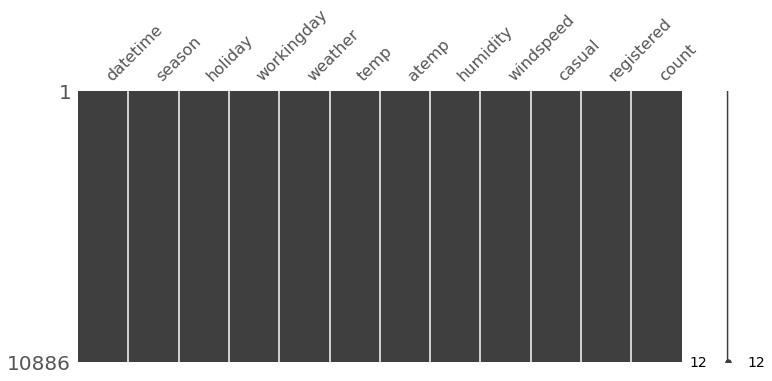

In [27]:
# null 값 시각화
import missingno as msno

msno.matrix(train, figsize=(12, 5))

위 그래프에 보이는 것처럼 일단 결측치는 잘 처리된 정형 데이터임을 확인하였습니다. 하지만 windspeed에 대한 0값은 다시 한번 고려해 볼만 하죠.

우리의 목표는 날짜별, 시간별 수요량을 예측해야 되기 때문에 train data의 datetime 칼럼을 좀더 세밀하게 나누어 유심히 살펴보도록 하겠습니다. (Feature Engineering 단계이지만 정확한 데이터 파악과 시각화를 위해 미리 해보도록 하겠습니다.)

In [28]:
# 새로운 (날짜, 시간) 칼럼 추가 - datetime의 Dtype이 datetime이므로 dt
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second

train.shape

(10886, 18)

In [29]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


우리는 이제 년도별, 월별, 날짜별 등 여러가지 세분화된 시각화 그래프를 그려볼 수 있을 것입니다.

## 2-1. 데이터 시각화(Visualization)
### Bar Chart
날짜별 시간별 자전거 수요량 시각화

In [30]:
# fm._rebuild() ＃한글 폰트 적용을 위함?

[Text(0, 0.5, '자전거 대여수'), Text(0.5, 1.0, '시간별 대여량')]

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_

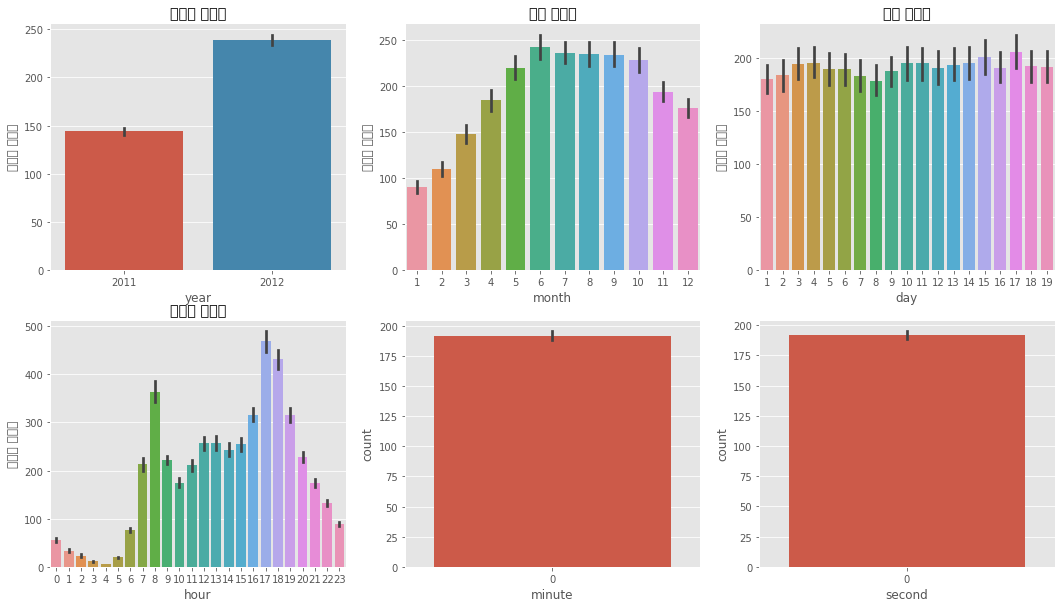

In [31]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18, 10)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)
sns.barplot(data=train, x='day', y='count', ax=ax3)
sns.barplot(data=train, x='hour', y='count', ax=ax4)
sns.barplot(data=train, x='minute', y='count', ax=ax5)
sns.barplot(data=train, x='second', y='count', ax=ax6)

ax1.set(ylabel='자전거 대여수', title='연도별 대여량')
ax2.set(ylabel='자전거 대여수', title='월별 대여량')
ax3.set(ylabel='자전거 대여수', title='일별 대여량')
ax4.set(ylabel='자전거 대여수', title='시간별 대여량')

# 그 이하는 의미 없음
# ax5.set(ylabel='자전거 대여수', title='연도별 대여량')
# ax6.set(ylabel='자전거 대여수', title='연도별 대여량')

위 bar chart 그래프로 미루어 보아, 알수 있는 점은:
- 연도별 대여량: 2011 < 2012 (추천 효과?)
- 월별 대여량: 6월 多多 > 7~10월 多 > ... > 1월 小 (날씨가 따뜻할 때 많이 대여)
- 일별 대여량: 1~19일 까지의 데이터 이므로 정보 부족. feature로 채택 불가
- 시간 대여량: 출퇴근 시간쯤의 대여량이 많음. (주중과 주말을 나누어 볼 필요)
- 분, 초: 값이 모두 0이므로 의미 없음

### Box plot
Box plot은 범주형 변수의 레벨에 따른 수치형 변수의 데이터 분포 정도를 비교 할 때 쓰입니다.
`season`, `holiday`, `workingday`, `weather` 그리고 datetime 변수와 달리 반복되는 `hour`(또는 `month`까지도?)도 범주형 변수라고 취급할 수 있기 때문에, 각 변수에 해당 레벨들에 따른 `Count` 수치형 변수의 분포 정도를 비교해 볼 수 있습니다.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_

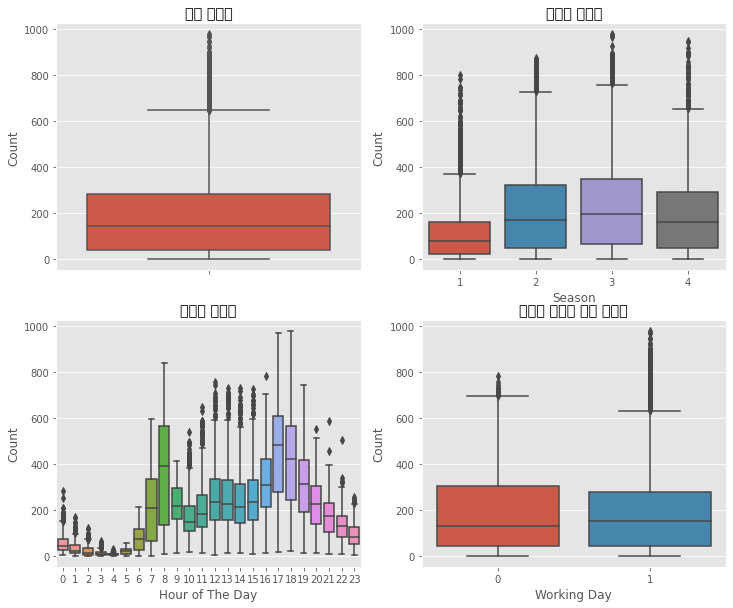

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train, y='count', orient='v', ax=axes[0][0])
sns.boxplot(data=train, x='season', y='count', orient='v', ax=axes[0][1])
sns.boxplot(data=train, x='hour', y='count', orient='v', ax=axes[1][0])
sns.boxplot(data=train, x='workingday', y='count', orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='Count', title='전체 대여량')
axes[0][1].set(xlabel='Season', ylabel='Count', title='계절별 대여량')
axes[1][0].set(xlabel='Hour of The Day', ylabel='Count', title='시간별 대여량')
axes[1][1].set(xlabel='Working Day', ylabel='Count', title='근무일 여부에 따른 대여량')


위 box plot 그래프로 미루어 보아, 알수 있는 점은:
- 전체적으로 100~300 사이 수준에서 대여를 하며 평균은 200에 못 미침.
- 봄에 대여량이 가장 적음
- 아까와 마찬가지로 출퇴근 시간에 수요가 많다. (오후 시간에 이상치들이 자주 관측된다?)
- 근무일과는 큰 차이가 없음 (미세하게 휴일(=0)에 대여량이 더 많긴 함.)

### Point plot
산점도 글리프를 사용하여 점 추정치와 신뢰 구간을 표시하는 그래프.
Point plot은 <u>하나 이상의 범주형 변수의 서로 다른 수준 간 비교 집중</u>할 때 자주 쓰입니다.

여기서는 시간에 따른 대여량이 근무요일, 요일, 날씨, 계절에 따라 어떻게 달라지는 지에 집중해보았습니다.

※ 다른 그래프보다는 계산량이 많아서 시간이 좀 소요됩니다.

In [33]:
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [34]:
train['dayofweek'].value_counts() # 데이터 값 별 관측 수 (Mon=0)

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

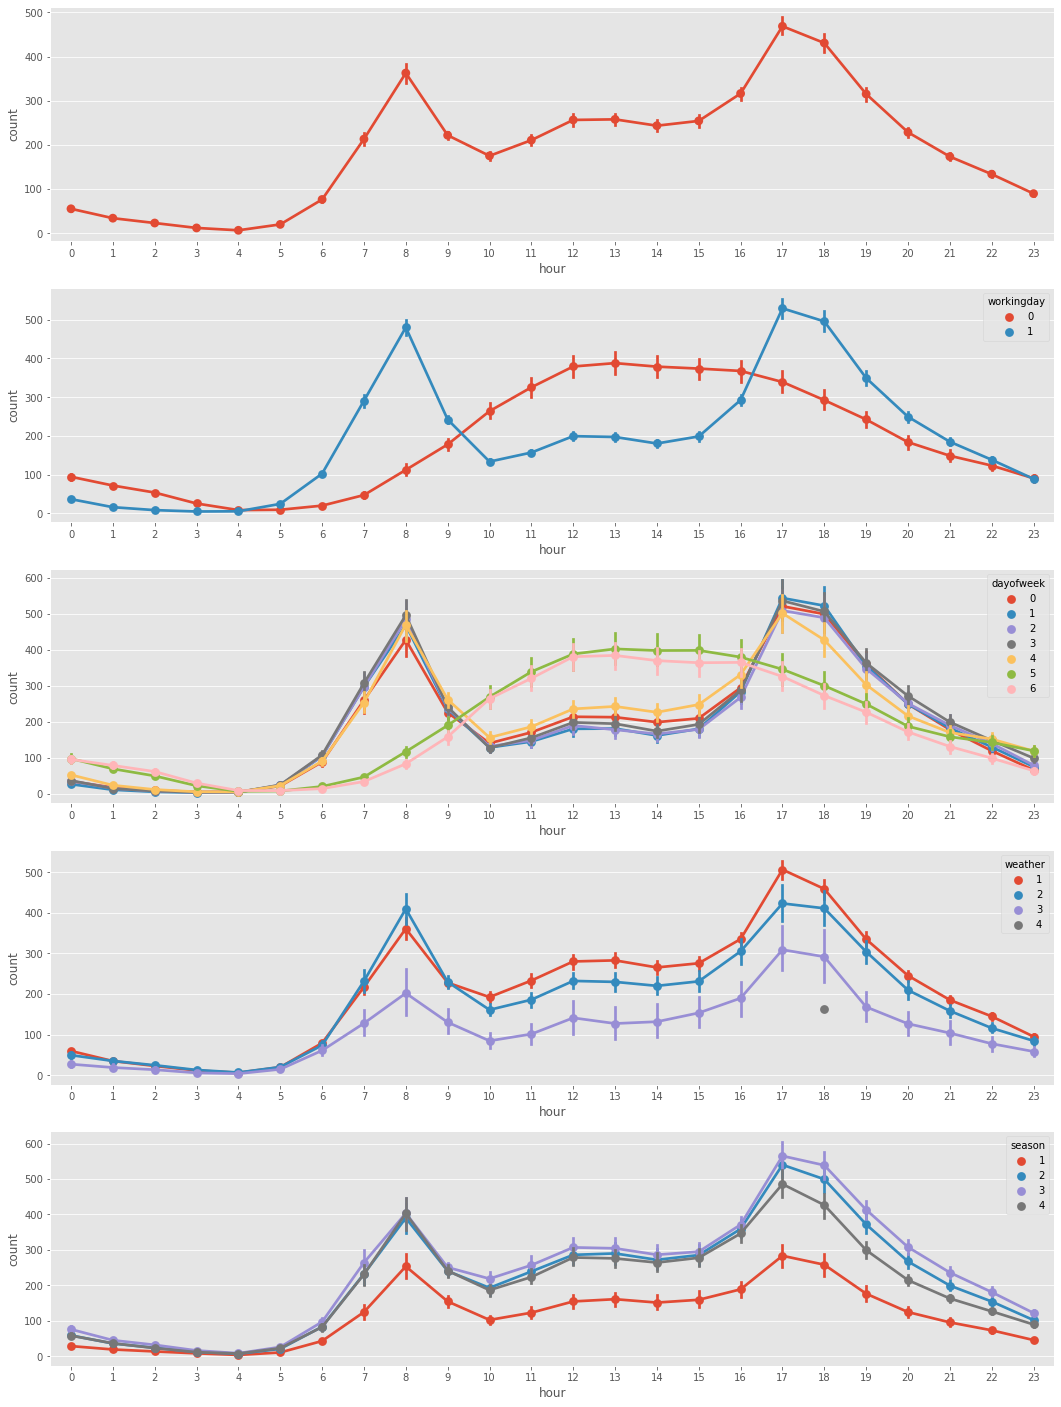

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18, 25)

sns.pointplot(data=train, x='hour', y='count', ax=ax1)
sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=train, x='hour', y='count', hue='dayofweek', ax=ax3)
sns.pointplot(data=train, x='hour', y='count', hue='weather', ax=ax4)
sns.pointplot(data=train, x='hour', y='count', hue='season', ax=ax5)

위 point plot 그래프로 미루어 보아, 알수 있는 점은:
- workingday, dayofweek 칼럼으로 보았을 때, 주중(일하는 요일)에는 출퇴근 시간에 소요량이 많지만 주말에는 대략 12시~16시 사이 오후 시간대에 수요가 많음.
- weather별로 봤을 때는 날씨가 좋음 > 흐림 > 눈 비 순으로 많이 대여함을 알 수 있음
- season별로 봤을 때는 가을 > 여름 > 겨울 > 봄 순으로 수요가 적어짐. (우리나라와 날씨, 온도가 달라서 우리의 상식과는 다른 예측이 나올 수도 있을 거 같음.)

### Heatmap (Correlation)
변수간의 상관관계를 살펴보도록 합시다.

In [36]:
corrMatt = train[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']]
corrMatt = corrMatt.corr()

pd.set_option('display.max_columns', 500) # cf. rows
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False # mask: heatmap 위 반 삼각형 여부

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


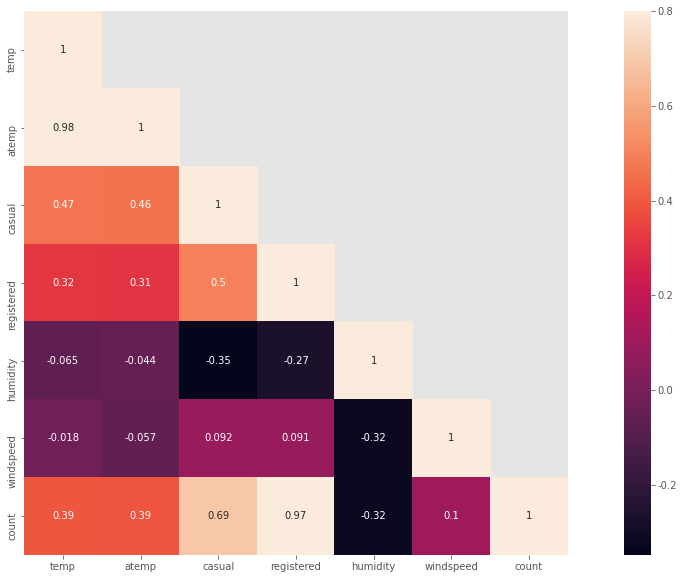

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True) # vmax: heatmap 고정값

위 heatmap 그래프로 미루어 보아, 알수 있는 점은:
- 온도(temp), 습도(humidity), 풍속(windspeed)는 거의 상관관계가 없음.
- 대여량(count)와 가장 연관이 높은건 registered. ※ 하지만, test data에는 이것에 대한 정보가 없음.
- 체감온도(atemp)와 온도(temp)는 0.98로 상관관계가 높지만, 온도와 체감온도를 feature로 사용하기에는 적합하지 않을 수 있음.

> 내 생각:
- atemp, temp는 [다중공선성](https://datascienceschool.net/03%20machine%20learning/06.04%20%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC%20%EB%B3%80%EC%88%98%20%EC%84%A0%ED%83%9D.html#id2)이 있지 않은가?  
- 이후 Feature Selection으로 쓰일 `feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity','windspeed', 'year', 'hour', 'dayofweek', 'holiday', 'workingday']`은 어떤 기준으로 결정된 것인가?

### regplot
도표 데이터(산점도)와 선형회귀 모델을 함께 그린 데이터

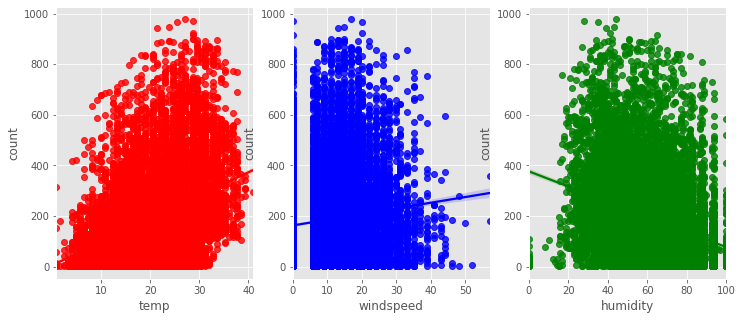

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)

sns.regplot(x='temp', y='count', data=train, ax=ax1, color='r')
sns.regplot(x='windspeed', y='count', data=train, ax=ax2, color='b')
sns.regplot(x='humidity', y='count', data=train, ax=ax3, color='g')

위 regplot 그래프로 미루어 보아, 알수 있는 점은:
- 풍속(windspeed) 0의 값이 몰려있는 걸 보아, 결측치를 대체한 값으로 보여짐. (feature engineering 시에 조정을 통해 모델을 성능을 높이자)
- 습도(humidity)도 0과 100에 몰려있는 경우가 있음.

## 더 다양한 세분화된 시각화
월별 시계열 데이터를 보기 위해 `datetime`변수를 조작하여 새로운 `year_month`칼럼을 만들어 보겠습니다.

In [39]:
# 월별 데이터 집계

# datetime형식 (2011-01-01 00:00:00) → concat_year_month 형식 (2011-1)
def concat_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train['year_month'] = train['datetime'].apply(concat_year_month)

print(train.shape)
train[['datetime', 'year_month']].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


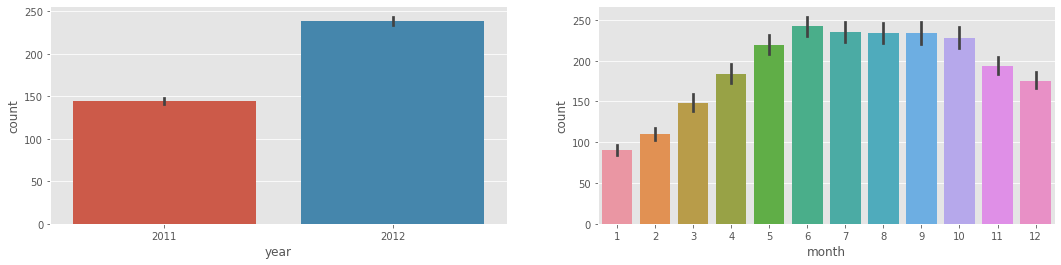

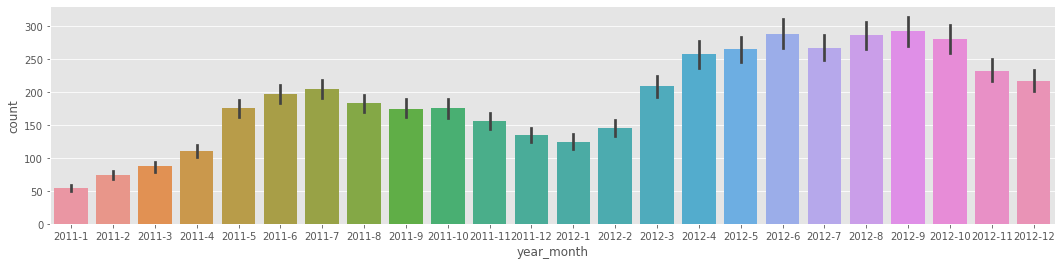

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year_month', y='count', ax=ax3)

위 barplot 그래프로 미루어 보아, 알수 있는 점은:
- 2011 < 2012 년 대여량 증가
- 월별 데이터로 보아, 계절의 특징에 따라 수요량 변화
- 년-월 데이터로 보아 전체적으로 수요가 늘어나는 추세.
- 같은 월, 다른 년과 비교했을 때는 더욱 명확

> 내 생각: 같은 월, 다른 년과 비교에 대한 그래프 만들어 보기

## 이상치(Outlier) 제거

In [41]:
# ESD 이상치 탐지법
trainWithoutOutliers = train[np.abs(train['count'] - train['count'].mean()) <= (3*train['count'].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


데이터의 분포를 (향후 모델 향상을 위해) 정규분포에 가깝게 자료 변환을 해줍니다. 여기서는 [log변환](https://rfriend.tistory.com/53)을 사용하여 정규 분포화 시켰습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.        , 0.        , 0.        , ..., 6.59578051, 6.5971457 ,
         6.59850903])),
 (1.40968461015429, 4.523106928071492, 0.9537631807794262))

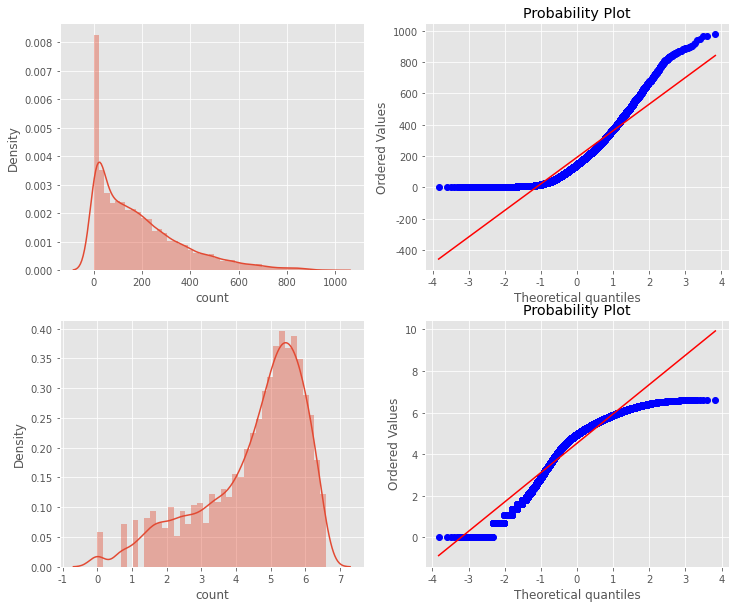

In [42]:
# count값의 데이터 분포도를 파악
figure, axes = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(12, 10)

sns.distplot(train['count'], ax=axes[0][0])
stats.probplot(train['count'], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers['count']), ax=axes[1][0])
stats.probplot(np.log(trainWithoutOutliers['count']), dist='norm', fit=True, plot=axes[1][1])

count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직합니다. 대안으로 outlier data를 제거하고 "count"변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있습니다.

참고 : [EDA & Ensemble Model (Top 10 Percentile) | Kaggle](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)

> 내 생각:
- 이상치 탐지를 다른 방법으로 써도 (Ex. [1.5 * IQR로 제거하는 법](https://lsjsj92.tistory.com/556)) 결과가 똑같을까? 이상치 탐지 및 제거 방법을 적합하게 고르는 방법은?
- 여기서 로그 변환을 왜 해봤을 까? 어차피 머신러닝 때 이용하지도 않을 거면서

## 3. Feature Engingeering
![](https://scikit-learn.org/stable/_static/ml_map.png)
이번 자전거 대여 수요량 같은 경우 시계열 데이터와 날씨 데이터를 이용하여 수요 수량을 예측하는 것이기 때문에 RandomForest와 다른 다양한 방법의 regression model를 이용하여 풀어볼 예정입니다.

주어진 데이터는 label(target)칼럼이 있기 때문에 supervised Machine Learning(지도 학습) 회귀 예측 문제라고 생각하고 진행하면 됩니다.
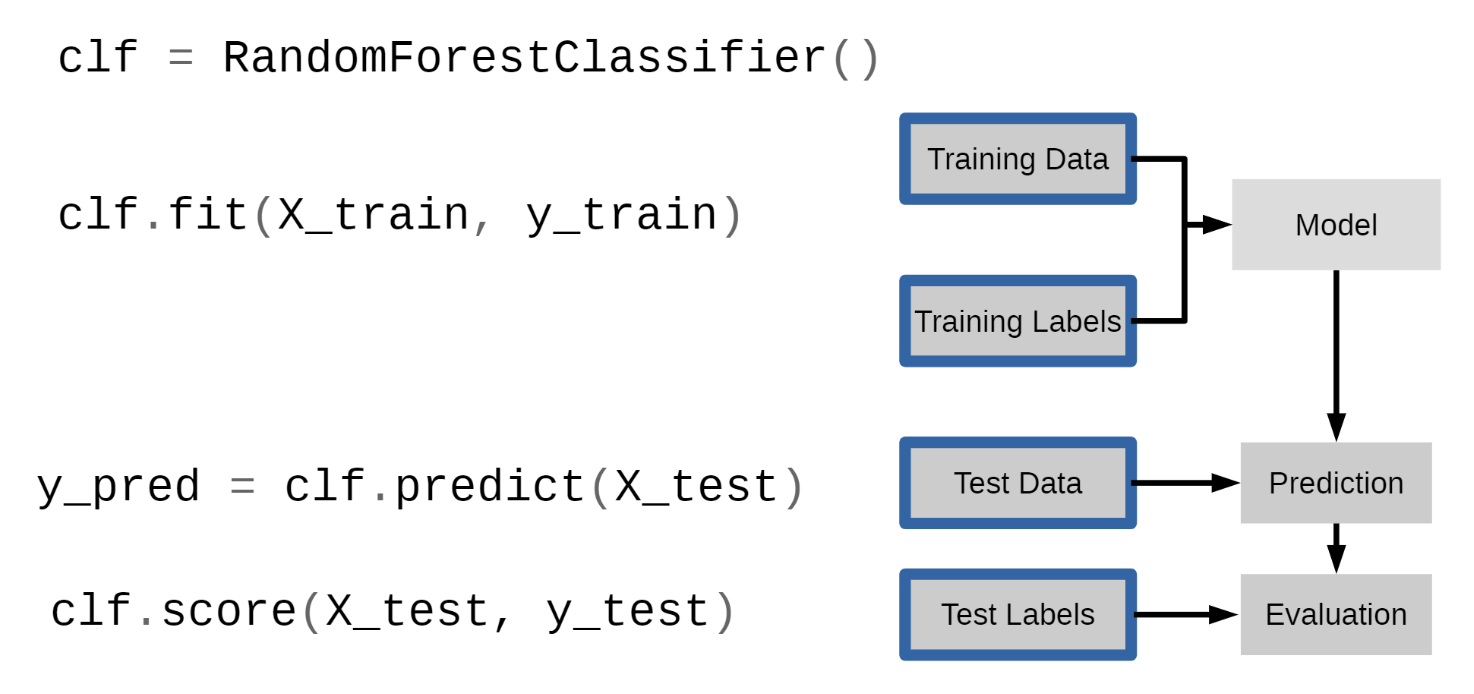

참고: [안드레아스 github](https://github.com/amueller/odscon-2015)

이번 대회의 Evaluation 방법은 **RMSLE**로 <u>과대평가 된 항목보다는 과소평가된 항목에 패널티를 주는 방식</u>입니다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 재곱근(Root)으로 값이 작을 수록 정밀도가 높습니다. 따라서, 0에 가까운 값이 나올수록 정밀도가 높다고 보면 됩니다.
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcMpUzP%2FbtqwHdHbYW2%2FhEC2CA3HqqvNl0hrcNBkl1%2Fimg.png)

참고: [실습으로 배우는 데이터 사이언스](https://programmers.co.kr/learn/courses/21/lessons/943)

우리는 이 방법으로 평가를 진행하도록 하겠습니다.
```python
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
```
또는 
```python
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # Numpy array(ndarray)형태로 변환
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제값에 1을 더하고 로그를 씌워준다
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱해준다.
    diff = log_predict - log_actual
    diff = np.square(diff) # diff ** 2

    # 평균
    mean_diff = diff.mean()

    # 루트를 씌운다.
    score = np.sqrt(mean_diff)

    return score
```
이렇게 해도 됩니다.

In [43]:
# 모델 평가 함수 생성
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # Numpy array(ndarray)형태로 변환
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제값에 1을 더하고 로그를 씌워준다
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱해준다.
    diff = log_predict - log_actual
    diff = np.square(diff) # diff ** 2

    # 평균
    mean_diff = diff.mean()

    # 루트를 씌운다.
    score = np.sqrt(mean_diff)

    return score